In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from kvae import VariationalAutoencoder

plt.style.use('ggplot')

%matplotlib inline

Using TensorFlow backend.


In [3]:
batch_size = 128
latent_dim = 2

intermediate_dims = [512, 256, 128, 64] # 137.45

epochs = 10

In [4]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_dim = x_train.shape[1]

x_train.shape, x_test.shape, input_dim

((60000, 784), (10000, 784), 784)

In [8]:
vae = VariationalAutoencoder(input_dim, intermediate_dims, latent_dim,
                             epsilon_std=0.3)

vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 784)           0                                            
____________________________________________________________________________________________________
dense_12 (Dense)                 (None, 512)           401920      input_3[0][0]                    
____________________________________________________________________________________________________
dense_13 (Dense)                 (None, 256)           131328      dense_12[0][0]                   
____________________________________________________________________________________________________
dense_14 (Dense)                 (None, 128)           32896       dense_13[0][0]                   
___________________________________________________________________________________________

/home/yannick/Work/github/Spikes/python/kvae.py:89: UserWarning: Output "custom_variational_layer_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_2" during training.
  vae.compile(optimizer='rmsprop', loss=None)


In [9]:
%%time

from random import seed

seed(42)

history = vae.fit(x_train,
                  shuffle=True,
                  epochs=20,
                  batch_size=batch_size,
                  validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s - loss: 187.6546 - val_loss: 164.9552
Epoch 2/20
60000/60000 [==============================] - 3s - loss: 159.1357 - val_loss: 154.2166
Epoch 3/20
60000/60000 [==============================] - 3s - loss: 151.2341 - val_loss: 148.3265
Epoch 4/20
60000/60000 [==============================] - 3s - loss: 147.7497 - val_loss: 147.7789
Epoch 5/20
60000/60000 [==============================] - 3s - loss: 145.4831 - val_loss: 143.8160
Epoch 6/20
60000/60000 [==============================] - 3s - loss: 143.8471 - val_loss: 144.2252
Epoch 7/20
60000/60000 [==============================] - 3s - loss: 142.3990 - val_loss: 143.5901
Epoch 8/20
60000/60000 [==============================] - 3s - loss: 141.3474 - val_loss: 141.7337
Epoch 9/20
60000/60000 [==============================] - 3s - loss: 140.4381 - val_loss: 140.1608
Epoch 10/20
60000/60000 [==============================] - 

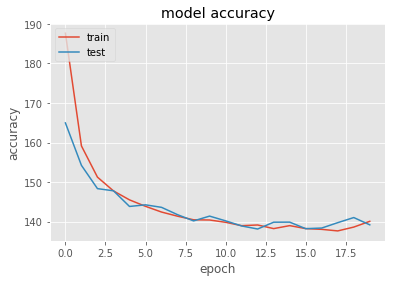

In [10]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
_ = plt.legend(['train', 'test'], loc='upper left')

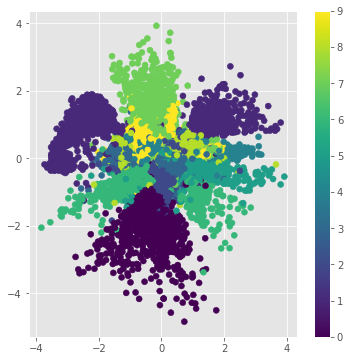

In [11]:
x_test_encoded = vae.encode(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()

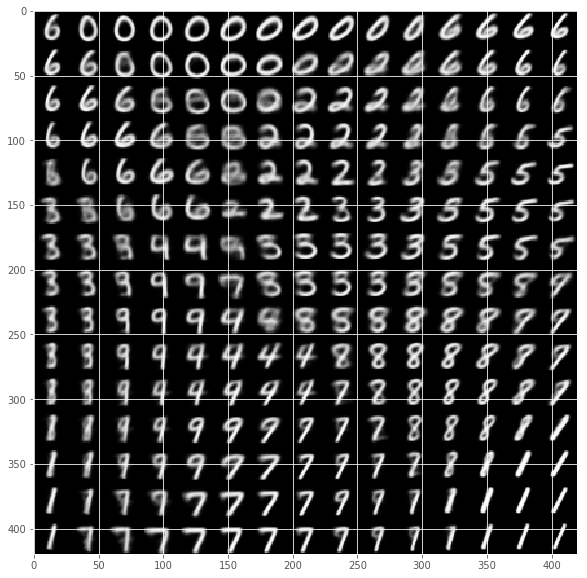

In [12]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.generate(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')

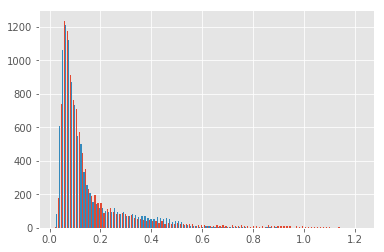

In [13]:
z_sigma_test = vae.sigmaEncode(x_test, batch_size=batch_size)

_ = plt.hist(z_sigma_test, bins=100)